In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import glob
import random
from PIL import Image

# CSE498R VGG16 with Confusion Matrix diff Custom, Fine tune also without Fine Tune

### Drive mount

In [3]:
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [4]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [5]:
download_dir = Path('/content/drive/MyDrive/NativeCarDataset')

In [6]:
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'

class_subset = sorted(os.listdir('/content/drive/MyDrive/NativeCarDataset/test'))[:13] # Using only the first 13 classes

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 5485 images belonging to 13 classes.
Found 959 images belonging to 13 classes.
Found 1618 images belonging to 13 classes.


In [7]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
from tensorflow.keras.optimizers import Adam
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=13

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 30

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

     |████████████████████████████████| 138 kB 28.9 MB/s 
0.5.3


In [10]:
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

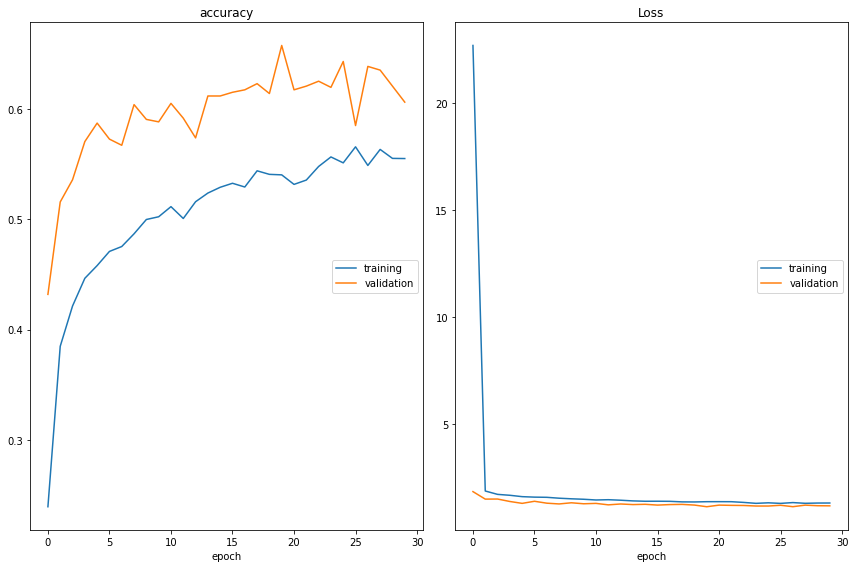

accuracy
	training         	 (min:    0.240, max:    0.566, cur:    0.555)
	validation       	 (min:    0.432, max:    0.657, cur:    0.606)
Loss
	training         	 (min:    1.321, max:   22.672, cur:    1.339)
	validation       	 (min:    1.165, max:    1.870, cur:    1.207)
60/60 [==============================] - 430s 7s/step - loss: 1.3387 - accuracy: 0.5549 - val_loss: 1.2071 - val_accuracy: 0.6060


In [ ]:
#%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=60,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 68.60%


In [11]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


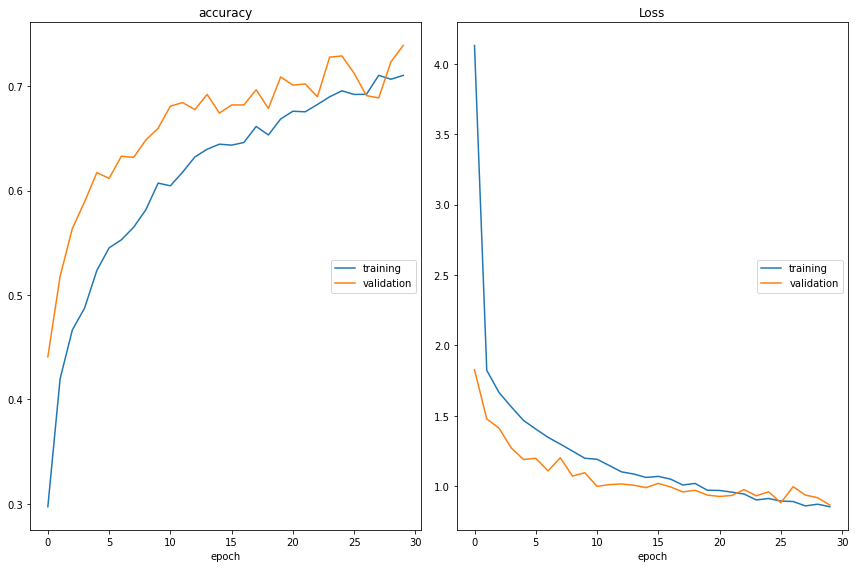

accuracy
	training         	 (min:    0.297, max:    0.710, cur:    0.710)
	validation       	 (min:    0.441, max:    0.739, cur:    0.739)
Loss
	training         	 (min:    0.854, max:    4.130, cur:    0.854)
	validation       	 (min:    0.866, max:    1.827, cur:    0.866)
85/85 [==============================] - 593s 7s/step - loss: 0.8540 - accuracy: 0.7102 - val_loss: 0.8660 - val_accuracy: 0.7388


In [12]:
#%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [13]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5')

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

In [19]:
from sklearn.metrics import accuracy_score
true_classes = testgen.classes
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 81.21%


In [15]:
from keras.models import load_model

scratch_model = load_model('/content/tl_model_v1.weights.best.hdf5')

scratch_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from keras.models import load_model

scratch_model = load_model('/content/tl_model_v1.weights.best.hdf5')

print("Fine tuning Model")
scratch_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Loading predictions from last article's model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'test',
                                             target_size=(224, 224),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)

scratch_preds = scratch_model.predict(testgen)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

scratch_acc = accuracy_score(true_classes, scratch_pred_classes)
print("From Scratch Model Accuracy with Fine-Tuning: {:.2f}%".format(scratch_acc * 100))

Found 3000 images belonging to 3 classes.
From Scratch Model Accuracy with Fine-Tuning: 33.33%


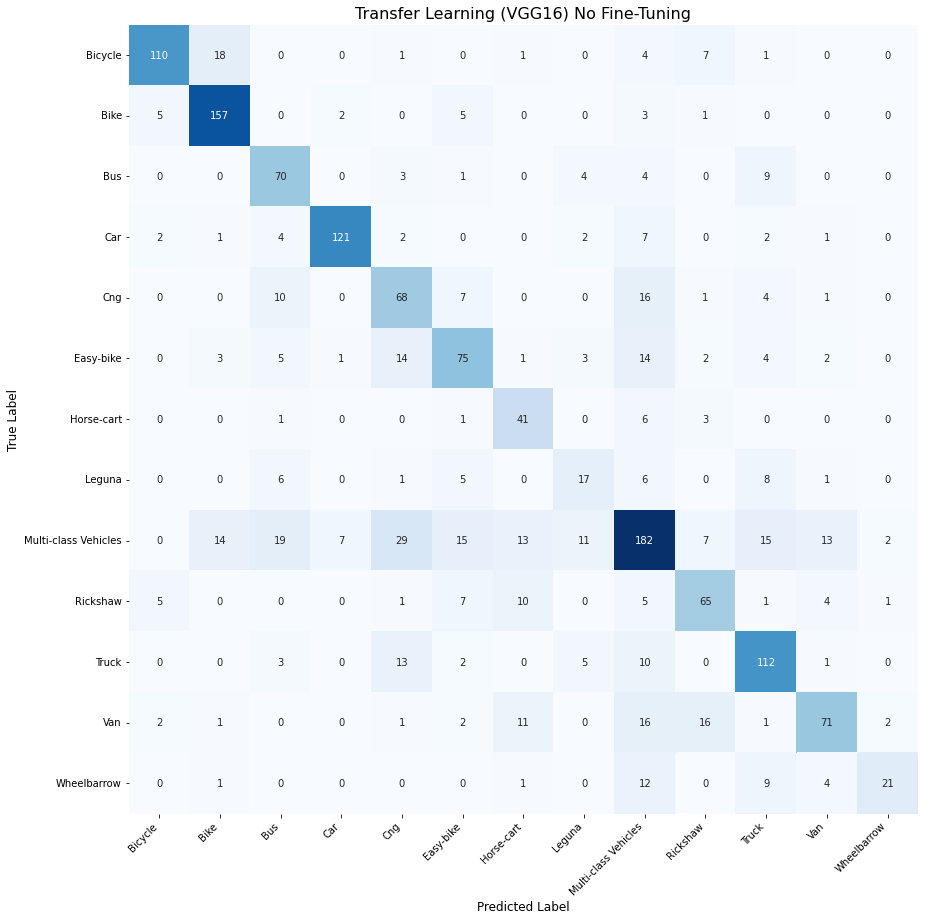

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax2) = plt.subplots(1, 1, figsize=(20, 10))

#plot_heatmap(true_classes, scratch_pred_classes, class_names, ax1, title="Custom CNN")    
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_classes,vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       142
           1       0.81      0.91      0.85       173
           2       0.59      0.77      0.67        91
           3       0.92      0.85      0.89       142
           4       0.51      0.64      0.57       107
           5       0.62      0.60      0.61       124
           6       0.53      0.79      0.63        52
           7       0.40      0.39      0.40        44
           8       0.64      0.56      0.59       327
           9       0.64      0.66      0.65        99
          10       0.67      0.77      0.72       146
          11       0.72      0.58      0.64       123
          12       0.81      0.44      0.57        48

    accuracy                           0.69      1618
   macro avg       0.67      0.67      0.66      1618
weighted avg       0.70      0.69      0.69      1618



In [ ]:
cm = confusion_matrix(true_classes, vgg_pred_classes)
TP = cm.diagonal()

precision_micro = TP.sum()/cm.sum()
recall_micro = TP.sum()/cm.sum()

precision_macro = np.nanmean(TP/cm.sum(0))
recall_macro = np.nanmean(TP/cm.sum(1))

print("")
print("Calculated:")
print("precision_micro:", precision_micro)
print("precision_macro:", precision_macro)
print("recall_micro:", recall_micro)
print("recall_macro:", recall_macro)


Calculated:
precision_micro: 0.6860321384425216
precision_macro: 0.6737325275626241
recall_micro: 0.6860321384425216
recall_macro: 0.6702833328318692


In [ ]:
f1 = (2*precision_macro*recall_macro)/(recall_macro+precision_macro)

print("F1 macro:",f1)

F1 macro: 0.6720035043029394


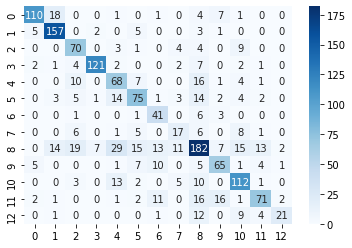

In [ ]:
#predict_y = vgg_model.predict(testgen)
predict_value = []
for predict in vgg_preds:
  if (predict>0.5).all():
    predict_value.append(1)
  else:
    predict_value.append(0)
from sklearn.metrics import confusion_matrix
conmatrix = confusion_matrix(true_classes,vgg_pred_classes)
import seaborn as sns
sns.heatmap(cm, annot=True,cmap="Blues",fmt="d",cbar=True,annot_kws={"size": 10})

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_classes,vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       142
           1       0.81      0.91      0.85       173
           2       0.59      0.77      0.67        91
           3       0.92      0.85      0.89       142
           4       0.51      0.64      0.57       107
           5       0.62      0.60      0.61       124
           6       0.53      0.79      0.63        52
           7       0.40      0.39      0.40        44
           8       0.64      0.56      0.59       327
           9       0.64      0.66      0.65        99
          10       0.67      0.77      0.72       146
          11       0.72      0.58      0.64       123
          12       0.81      0.44      0.57        48

    accuracy                           0.69      1618
   macro avg       0.67      0.67      0.66      1618
weighted avg       0.70      0.69      0.69      1618



## **(VGG16) with Fine-Tuning**

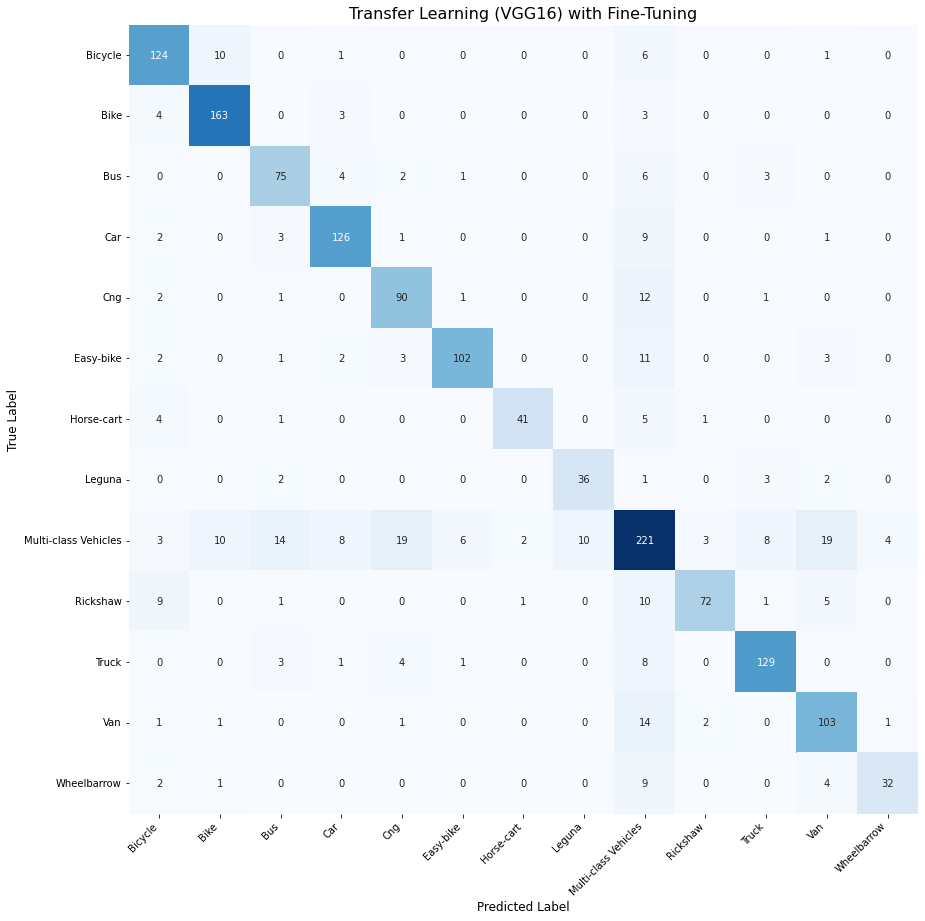

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax3) = plt.subplots(1, 1, figsize=(20, 10))

#plot_heatmap(true_classes, scratch_pred_classes, class_names, ax1, title="Custom CNN")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax2, title="Transfer Learning (VGG16) with Fine-Tuning")    
plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(true_classes,vgg_pred_classes_ft))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       142
           1       0.88      0.94      0.91       173
           2       0.74      0.82      0.78        91
           3       0.87      0.89      0.88       142
           4       0.75      0.84      0.79       107
           5       0.92      0.82      0.87       124
           6       0.93      0.79      0.85        52
           7       0.78      0.82      0.80        44
           8       0.70      0.68      0.69       327
           9       0.92      0.73      0.81        99
          10       0.89      0.88      0.89       146
          11       0.75      0.84      0.79       123
          12       0.86      0.67      0.75        48

    accuracy                           0.81      1618
   macro avg       0.83      0.81      0.82      1618
weighted avg       0.82      0.81      0.81      1618

